In this notebook, we construct an adversial for DP in collaborative learning

In [0]:
%load_ext tensorboard

import os
import numpy as np
import math
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


class Namespace:
    # Used to pass arguments
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


os.makedirs("images", exist_ok=True)
os.makedirs("./models", exist_ok=True)


opt = Namespace(n_epochs = 200, batch_size = 64, lr = 2e-4, b1 = 0.5,
                b2 = 0.999, latent_dim = 100, img_size = 32, channels = 1, 
                sample_interval = 1000)


cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if cuda else "cpu")


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# MNIST 


In [0]:
# Configure data loader
os.makedirs("./data/mnist_train", exist_ok=True)
os.makedirs("./data/mnist_test", exist_ok=True)
trainloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist_train",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)


testloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist_test",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# LeNet

In [0]:
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

### Train LeNet

In [0]:
def train_one_epoch(model, loader, optimizer, criterion, device, writer, epoch):
    model.train()
    running_loss = 0.0
    for batch_id, (imgs, labels) in enumerate(loader):    
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
    
        outputs = model(imgs)
        loss = criterion(outputs, labels)
    
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_id % 100 == 99:
            writer.add_scalar('training loss',
                            running_loss / 100,
                            epoch * len(loader) + batch_id)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * len(loader.dataset), len(loader.dataset),
                       100. * batch_id / len(loader), running_loss / 100))
            
            running_loss = 0.0
            
            writer.flush()
            
    
    writer.add_scalar('Train/Loss', loss.item(), epoch)
    writer.flush()


def test(model, loader, criterion, writer):
    model.eval()
    i, loss, correct, n = [0, 0, 0, 0]
    
    print("Testing..")
    with torch.no_grad():

        for batch_id, (imgs, labels) in enumerate(loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss += criterion(outputs, labels)

            preds = outputs.data.max(1)[1] 
            correct += preds.eq(labels.data).cpu().sum()

    loss /= len(loader)  # loss function already averages over batch size
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(loader.dataset),
        accuracy))
    
    # Record loss and accuracy into the writer
    writer.add_scalar('Test/Loss', loss, epoch)
    writer.add_scalar('Test/Accuracy', accuracy, epoch)
    writer.flush()
    return accuracy

In [5]:
PATH_to_log_dir = './logdir'
if not os.path.exists(PATH_to_log_dir):
    os.makedirs(PATH_to_log_dir)
    
%tensorboard --logdir {PATH_to_log_dir}

Reusing TensorBoard on port 6006 (pid 176), started 0:14:37 ago. (Use '!kill 176' to kill it.)

In [6]:
num_epochs = 7
lr_ = 1e-4
model_name = "LeNet5"

model = LeNet5()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_)

timestr = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(os.path.join(PATH_to_log_dir ,timestr))

best_acc = 0.
for epoch in range(0, num_epochs):
    print("Epoch %d" % epoch)
    train_one_epoch(model, trainloader, optimizer, criterion, device, writer, epoch)
    acc = test(model, testloader, criterion, writer)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, "./models/" + str(model_name) + "_best.pth")
    writer.close()

Epoch 0
Train Epoch: 0 [5940000/60000 (11%)]	Loss: 2.246321
Train Epoch: 0 [11940000/60000 (21%)]	Loss: 1.717308
Train Epoch: 0 [17940000/60000 (32%)]	Loss: 0.896245
Train Epoch: 0 [23940000/60000 (43%)]	Loss: 0.589392
Train Epoch: 0 [29940000/60000 (53%)]	Loss: 0.463970
Train Epoch: 0 [35940000/60000 (64%)]	Loss: 0.404625
Train Epoch: 0 [41940000/60000 (75%)]	Loss: 0.365470
Train Epoch: 0 [47940000/60000 (85%)]	Loss: 0.336711
Train Epoch: 0 [53940000/60000 (96%)]	Loss: 0.325565
Testing..

Test set: Average loss: 0.2665, Accuracy: 9218/10000 (92%)

Epoch 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 1 [5940000/60000 (11%)]	Loss: 0.277617
Train Epoch: 1 [11940000/60000 (21%)]	Loss: 0.266738
Train Epoch: 1 [17940000/60000 (32%)]	Loss: 0.234599
Train Epoch: 1 [23940000/60000 (43%)]	Loss: 0.215751
Train Epoch: 1 [29940000/60000 (53%)]	Loss: 0.226016
Train Epoch: 1 [35940000/60000 (64%)]	Loss: 0.217899
Train Epoch: 1 [41940000/60000 (75%)]	Loss: 0.202667
Train Epoch: 1 [47940000/60000 (85%)]	Loss: 0.197128
Train Epoch: 1 [53940000/60000 (96%)]	Loss: 0.167799
Testing..

Test set: Average loss: 0.1536, Accuracy: 9539/10000 (95%)

Epoch 2
Train Epoch: 2 [5940000/60000 (11%)]	Loss: 0.181079
Train Epoch: 2 [11940000/60000 (21%)]	Loss: 0.155157
Train Epoch: 2 [17940000/60000 (32%)]	Loss: 0.161857
Train Epoch: 2 [23940000/60000 (43%)]	Loss: 0.149608
Train Epoch: 2 [29940000/60000 (53%)]	Loss: 0.149854
Train Epoch: 2 [35940000/60000 (64%)]	Loss: 0.147892
Train Epoch: 2 [41940000/60000 (75%)]	Loss: 0.143356
Train Epoch: 2 [47940000/60000 (85%)]	Loss: 0.131016
Train Epoch: 2 [539400

In [7]:
img, _ = next(iter(trainloader))

output = model(img.to(device))
res = F.softmax(output, dim=1)

res[:, 0]

tensor([2.3235e-06, 5.4258e-08, 5.7378e-11, 1.7416e-08, 9.9855e-01, 9.9923e-01,
        1.0193e-05, 4.3408e-05, 3.3350e-05, 1.4219e-06, 9.9860e-01, 3.9288e-07,
        3.0066e-07, 6.0348e-07, 2.7679e-09, 1.4538e-08, 1.1358e-07, 4.2482e-05,
        9.9869e-01, 3.7497e-08, 7.1216e-06, 3.9815e-07, 9.9861e-01, 1.3994e-06,
        5.9978e-03, 3.3334e-07, 1.0184e-09, 1.3032e-05, 4.8501e-08, 1.5022e-06,
        2.4689e-09, 3.5725e-07, 6.1094e-05, 1.8702e-08, 5.7427e-03, 2.0629e-06,
        4.2285e-06, 2.8395e-04, 7.9673e-04, 2.4727e-08, 2.1833e-09, 6.6166e-05,
        2.1868e-06, 1.6934e-04, 1.5879e-07, 8.5412e-07, 7.5013e-04, 1.5711e-08,
        2.8374e-02, 4.6580e-09, 1.1579e-05, 1.4288e-05, 5.3571e-05, 8.3961e-07,
        3.6858e-06, 1.3512e-10, 2.2741e-04, 7.8401e-06, 4.1192e-06, 8.4568e-08,
        4.7419e-04, 7.2219e-04, 8.8819e-08, 1.8279e-05], device='cuda:0',
       grad_fn=<SelectBackward>)

Generating images from trained model

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, model, target_class):
        super(Discriminator, self).__init__()
        self.model = model
        self.target_class = target_class

    def forward(self, x):
        output = F.softmax(self.model(x), dim=1)
        return output[:, self.target_class]

In [0]:
class_ = 3

# Initialize generator 
generator = Generator()
discriminator = Discriminator(model, target_class=class_)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

if cuda:
    generator.cuda()
    discriminator.cuda()

# Initialize weights
generator.apply(weights_init_normal)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [10]:
bz = 64

adversarial_loss = nn.BCELoss()

global_loss = 0.

for i in range(int(5*1e4)+1):
    optimizer_G.zero_grad()

    valid = Variable(Tensor(bz).fill_(1.0), requires_grad=False)
    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (bz, opt.latent_dim))))

    # Generate a batch of images
    gen_imgs = generator(z)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)

    g_loss.backward()
    optimizer_G.step()

    global_loss += g_loss.data

    batches_done =  i
    if batches_done % opt.sample_interval == 0 and i > 0 :
        print("[Batch %d/%d] [G loss: %f]"
                % (i, int(5*1e4), global_loss))
        global_loss = 0
        save_image(gen_imgs.data[:25]/2 + 0.5, "images/%d.png" % batches_done, nrow=5, normalize=True)

[Batch 1000/50000] [G loss: 36.082027]
[Batch 2000/50000] [G loss: 0.165745]
[Batch 3000/50000] [G loss: 0.063497]
[Batch 4000/50000] [G loss: 0.031954]
[Batch 5000/50000] [G loss: 0.018243]
[Batch 6000/50000] [G loss: 0.010910]
[Batch 7000/50000] [G loss: 0.006788]
[Batch 8000/50000] [G loss: 0.004319]
[Batch 9000/50000] [G loss: 0.002795]
[Batch 10000/50000] [G loss: 0.001847]
[Batch 11000/50000] [G loss: 0.001218]
[Batch 12000/50000] [G loss: 0.000807]
[Batch 13000/50000] [G loss: 0.000536]
[Batch 14000/50000] [G loss: 0.000356]
[Batch 15000/50000] [G loss: 0.000240]
[Batch 16000/50000] [G loss: 0.000163]
[Batch 17000/50000] [G loss: 0.000108]
[Batch 18000/50000] [G loss: 0.000071]
[Batch 19000/50000] [G loss: 0.000044]
[Batch 20000/50000] [G loss: 0.000027]
[Batch 21000/50000] [G loss: 0.000016]
[Batch 22000/50000] [G loss: 0.000010]
[Batch 23000/50000] [G loss: 0.000006]
[Batch 24000/50000] [G loss: 0.000004]
[Batch 25000/50000] [G loss: 0.000003]
[Batch 26000/50000] [G loss: 0.00

# Generate one image

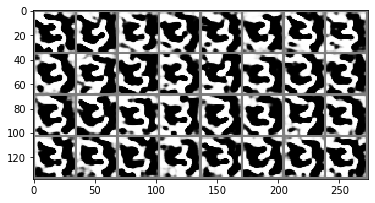

In [35]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def imshow(inp):
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    inp = 0.5 * inp + 0.5
    plt.imshow(inp)


z = Variable(Tensor(np.random.normal(0, 1, (32, opt.latent_dim))))
gen_img = generator(z)

out = torchvision.utils.make_grid(gen_img)

imshow(out)
